<a href="https://colab.research.google.com/github/kushalnavghare/DataHack-Summit-2019/blob/master/Keras_Workshop_Introduction_To_Deep_Learning_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modern Deep Learning: 
# Classify Fashion-MNIST with a simple CNN in Keras

Original version from https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a, adapted & extended by Xander Steenbrugge.
![alt text](https://github.com/margaretmz/deep-learning/blob/master/images/modern%20dl_fash-mnist_keras.png?raw=1)

## Why Jupyter Notebook?


*   Interactive programming in the web browser
*   Great for visualization
*   Great for collabration
*   Popular tool for studying machine learning / deep learning




## Why Fashion-MNIST?


*   MNIST is too easy
*   MNIST is overused
*   MNIST can not represent modern Computer Vision tasks

Read more about the Fashion-MINST dataset in this paper [here](https://arxiv.org/abs/1708.07747) (**Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms**)



## Notebook Overview

This is a tutorial of how to classify **fashion_mnist** data with a simple **Convolutional Neural Network** in Keras. 
Keras is now part of the core TensorFlow library, in addition to being an independent open source project. 

We will work our way to an efficiently regularized, convolutional network in small, incremental steps, starting from a simple, linear model and gradually adding more and more complexity to our neural network.


The [fashion_mnist](https://github.com/zalandoresearch/fashion-mnist) data: 
60,000 train and 10,000 test data with 10 categories. Each gray-scale image is 28x28.

<br> **Label**	**Description**
<br> 0 T-shirt/top
<br> 1 Trouser
<br> 2 Pullover
<br> 3 Dress
<br> 4 Coat
<br> 5 Sandal
<br> 6 Shirt
<br> 7 Sneaker
<br> 8 Bag
<br> 9 Ankle boot

Each gray-scale image is 28x28

# Setup
First, install TensorFlow version 1.8.0 and import the Fashion-MNIST dataset
We will also be using numpy, matplotlib and the native Keras package, so install those if you haven't already!

Check the requirements.txt file for all necessary dependencies!

In [0]:
#Test your imports:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

# 1 Data prep

## 1.0 Download the fashion_mnist data
Now, let's download fashion-mnist which is one of the Keras datasets: https://keras.io/datasets/
Pull the dataset from disk into cache memory by storing it in numpy arrays.
As a sanity check, print some shapes to make sure everything is as expected! You should have images of 28 by 28 pixels.

In [0]:
# Load the fashion-mnist pre-shuffled train data and test data
(x_train_data, y_train_data), (x_test_data, y_test_data) = tf.keras.datasets.fashion_mnist.load_data()
# Define the text labels:
dataset_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

#Print some shapes of the data:
print("x_train shape:", x_train_data.shape, "y_train shape:", y_train_data.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


## 1.1 Visualize the data
Before we start defining any models, lets have a look at our data to get a sense of what we're dealing with.
Use matplotlib to visualise some of the training images, can you identify the classes yourself?
Perhaps create a simple, callable function that plots a dataset image, given its index.

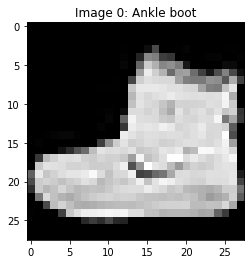

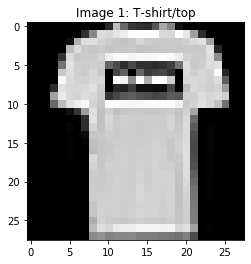

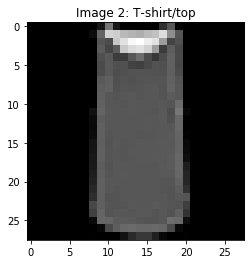

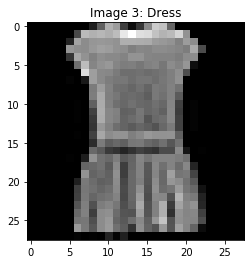

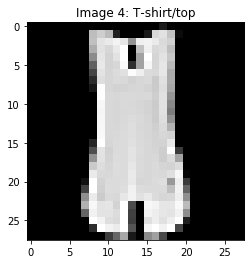

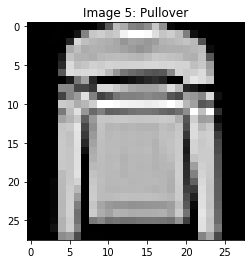

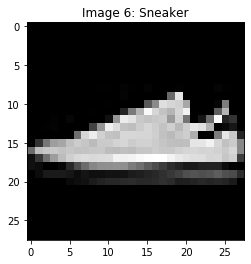

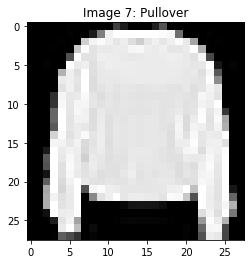

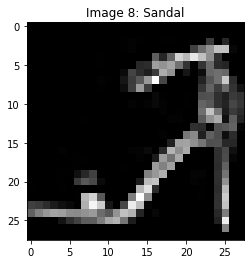

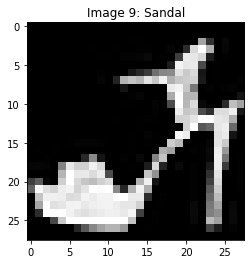

In [0]:
def plot_image(img_index):
    # y_train contains the lables, ranging from 0 to 9
    label_index = y_train_data[img_index]
    plt.imshow(x_train_data[img_index], cmap = 'gray')
    plt.title("Image %d: %s" %(img_index, dataset_labels[label_index]))
    plt.show()
    
 
# Image index, you can pick any number between 0 and 59,999
 
for i in range(10):
  plot_image(i)


## 1.2 Data normalization
First investigate the range of the pixel values in the images: what are the min and max you find?

For a neural network to work well, we want these pixel values to be within the range 0-1. Rescale the image pixel values to make this so!

In [0]:
print("Dataset samples have min of %.1f and max of %.1f." %(np.min(x_train_data), np.max(x_train_data)))
 
x_train_data = x_train_data.astype('float32') / 255
x_test_data = x_test_data.astype('float32') / 255
 
print("After rescaling, images now have min of %.1f and max of %.1f." %(np.min(x_train_data), np.max(x_train_data)))

Dataset samples have min of 0.0 and max of 255.0.
After rescaling, images now have min of 0.0 and max of 1.0.


## 1.3 Split the data into train/validation/test data sets
In Machine Learning, we always want to be able to validate how well our model is doing on data it hasn't yet trained on.

*   Training data - used for training the model
*   Validation data - used for tuning the hyperparameters and evaluate the models
*   Test data - used to test the model after the model has gone through initial vetting by the validation set.

Split off 10% of the training data and put this into the validation set!

In [0]:
validation_fraction = .1
 
total_train_samples = len(x_train_data)
validation_samples = int(total_train_samples * validation_fraction)
train_samples = total_train_samples - validation_samples
 
# Further break training data into train / validation sets
(x_train, x_valid) = x_train_data[:train_samples], x_train_data[train_samples:] 
(y_train, y_valid) = y_train_data[:train_samples], y_train_data[train_samples:]
x_test, y_test = x_test_data.copy(), y_test_data.copy()
print("We'll use %d train - %d validation - %d test images." %(train_samples, validation_samples, len(x_test)))

We'll use 54000 train - 6000 validation - 10000 test images.


In [0]:
len(x_valid), len(x_train)

(6000, 54000)

## 1.4 Some final preprocessing
Most image datasets consist of rgb images. Because of this, Keras will expect each image to have 3 dimensions: [x_pixels, y_pixels, color_channels]. Since our images are grayscale, the color dimension is equal to one and implicitly left out in the numpy arrays. Reshape the image data to contain an explicit color channel of dimension 1. (Your final numpy arrays should have the dimension [nr_samples, x_pixels, y_pixels, 1].)

Secondly, it is very common in deep learning to do classification tasks. To train our model, we will use the categorical crossentropy loss (see https://keras.io/losses/). To compute this, we have to format our image labels as one-hot-vectors. The easiest way to do this is with the tf.keras.utils.to_categorical() function, see: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical.

In [0]:
# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)
 
# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
 
# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
 
# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')

x_train shape: (54000, 28, 28, 1) y_train shape: (54000, 10)
54000 train set


In [0]:
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

6000 validation set
10000 test set


# 2 Creating a model

There are two APIs for defining a model in Keras:
1. [Sequential model API](https://keras.io/models/sequential/)
2. [Functional API](https://keras.io/models/model/)

In this notebook we are using the Sequential model API. 
If you are interested in a tutorial using the Functional API, checkout Sara Robinson's blog [Predicting the price of wine with the Keras Functional API and TensorFlow](https://medium.com/tensorflow/predicting-the-price-of-wine-with-the-keras-functional-api-and-tensorflow-a95d1c2c1b03).

In defining the models today, we will be using some of these Keras APIs: (you can check the documentation with these links:)
*   Dense()    [link text](https://keras.io/layers/core/) - Create a fully connected layer
*   Conv2D()   [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D/) - create a convolutional layer 
*   Pooling()  [link text](https://keras.io/layers/pooling/) - create a pooling layer 
*   Dropout()  [link text](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - apply drop out 

## 2.0 Baseline: a simple linear model
As a first baseline, we will create a very simple, linear model consisting of one linear transformation matrix and train it with backpropagation.

*  To create the model object, use the tf.keras.Sequential() function as shown here: https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential.
Since we're not using convolutions for now, we can simply flatten all input pixels into a single row per image containing 28x28 pixel values.

*  Then add a single, linear layer that maps all these pixels onto the 10 output classes. Since the outputs represent class probabilities we can use a softmax activation at the output of our model.

*  You can print a description of your model using model.summary()

Extra question: what does the softmax activation actually do? How does this affect our training procedure?
Here is a good post explaining most of the details: https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d

In [0]:
model = tf.keras.Sequential()
 
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
 
# Take a look at the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Compile the model
Configure the learning process with compile() API before training the model. It receives three arguments:

*   An optimizer, we'll use adam
*   A loss function, we'll use the 'categorical_crossentropy'
*   A list of metrics, here we'll start with 'accuracy'

See https://keras.io/models/model/ for details.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

Now let's train the model with fit() API.

We use  the [ModelCheckpoint](https://keras.io/callbacks/#modelcheckpoint) API to save the model after every epoch. Set "save_best_only = True" to save only when the validation accuracy improves.

You will also have to configure the batch-size and the number of epochs to train for.
What do these words mean exactly?

In [0]:
#import keras.callbacks
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53376/54000 [============================>.] - ETA: 0s - loss: 0.6796 - acc: 0.7734
Epoch 00001: val_loss improved from inf to 0.51286, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 3s 57us/sample - loss: 0.6780 - acc: 0.7740 - val_loss: 0.5129 - val_acc: 0.8263
Epoch 2/10
53504/54000 [============================>.] - ETA: 0s - loss: 0.4885 - acc: 0.8358
Epoch 00002: val_loss improved from 0.51286 to 0.46343, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 3s 53us/sample - loss: 0.4893 - acc: 0.8354 - val_loss: 0.4634 - val_acc: 0.8418
Epoch 3/10
52928/54000 [============================>.] - ETA: 0s - loss: 0.4563 - acc: 0.8459
Epoch 00003: val_loss improved from 0.46343 to 0.44144, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 3s 50us/sample - loss: 0.4568 - acc: 0.8457 - val_loss: 0.4414 - val_acc: 0.844

## Load Model with the best validation accuracy
Use the .load_weights() function for this!

In [0]:
# Load the weights with the best validation accuracy:
model.load_weights('model.weights.best.hdf5')

## Test Accuracy
Since we used our validation set to choose the best model, we are implicitly already overfitting on this subset of the data. To get the final accuracy estimate our model would get on completely unseen data, compute the accuracy on the test set! Use the .evaluate() function for this.

In [0]:
# Evaluate the model on test set, and print the accuracy you get:
score = model.evaluate(x_test, y_test, verbose = 0)

print(score)

[0.44372755579948425, 0.8447]


## Visualize prediction
Now let's visualize the predictions from the model you just trained. 
First we get the predictions with the model from the test data.
Then we visualize some images from the test data set, and set the titles with the prediction (and the groud truth label).
If the prediction matches the true label, the title will be green; otherwise it's displayed in red.
Package everything in a nice, callable function 'visualize_model_predictions(model, x, y)'

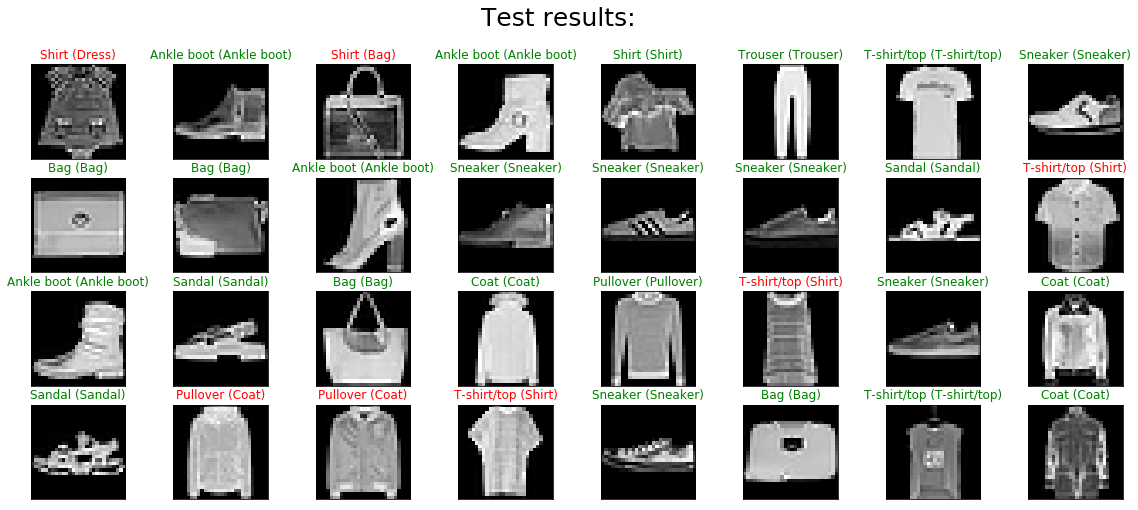

In [0]:
def visualize_model_predictions(model, x_test, y_test, title_string):
    y_hat = model.predict(x_test)
 
    # Plot a random sample of 10 test images, their predicted labels and ground truth
    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
        ax = figure.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
        # Display each image
        ax.imshow(np.squeeze(x_test[index]), cmap = 'gray')
        predict_index = np.argmax(y_hat[index])
        true_index = np.argmax(y_test[index])
        # Set the title for each image
        ax.set_title("{} ({})".format(dataset_labels[predict_index], 
                                      dataset_labels[true_index]),
                                      color=("green" if predict_index == true_index else "red"))
    figure.suptitle("%s results:" %title_string, fontsize=25)
        
visualize_model_predictions(model, x_test, y_test, 'Test')

## Extra Assignment:
Visualise what this single, linear layer has learned to detect for each class by plotting the weights of trained network.
Our transformation layer is a weight matrix of dimension [28x28, 10]. In a sense, it has learned a 'filter' for each of the 10 classes. Try to plot what these 10 filters look like, by reshaping them into 28x28 images and visualising the results for each class with matplotlib.imshow().

To get the weight matrix of your trained model, you can use the model.layers and .get_weights() functions.

## Extra Assignment 2:
Compare the filters you just plotted with the average image for each class, do you notice any differences? Why?

TypeError: ignored

## Extra assignment 3:
Change the code in block 1.0 to work with MNIST instead of Fashion-MNIST (everything else can stay the same). Rerun all the code you've written so far.

What Test-accuracy do you get with a simple, linear model? Can you see now why MNIST is gradually losing favor as a benchmarking dataset? What about the filter visualisations VS the average images, they look interesting right? Try to think about what exactly is going on here...

# 2.1 Let's turn this into a real neural network!
Add a single hidden layer to the model and add an activation function after that layer (eg 'relu').
The number of hidden units in this layer is usually something in between the input dimension (28x28) and the output dimension (10). Play around with the activation function and the number of hidden units, how do they affect the models performance / training speed?

In [0]:
model = tf.keras.Sequential()

# Flatten --> Dense_Relu --> Dense_Softmax:
 
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
 
# Take a look at the model summary
model.summary()

# Take a look at the model summary:
#model.summary()

#Compile the model:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [0]:
## Add a checkpointer and fit the model on the train data: (you have already done this, see above!)

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=25,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Train on 54000 samples, validate on 6000 samples
Epoch 1/25
53312/54000 [============================>.] - ETA: 0s - loss: 0.5640 - acc: 0.8074
Epoch 00001: val_loss improved from inf to 0.44001, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 3s 58us/sample - loss: 0.5629 - acc: 0.8076 - val_loss: 0.4400 - val_acc: 0.8478
Epoch 2/25
53824/54000 [============================>.] - ETA: 0s - loss: 0.4127 - acc: 0.8574
Epoch 00002: val_loss improved from 0.44001 to 0.41417, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 3s 55us/sample - loss: 0.4126 - acc: 0.8574 - val_loss: 0.4142 - val_acc: 0.8475
Epoch 3/25
53312/54000 [============================>.] - ETA: 0s - loss: 0.3786 - acc: 0.8664
Epoch 00003: val_loss improved from 0.41417 to 0.37784, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 3s 54us/sample - loss: 0.3786 - acc: 0.8663 - val_loss: 0.3778 - val_acc: 0.863

## Evaluation
Load the best model (according to the validation set) and compute the test accuracy. Re-use your 'visuzalize_model_predictions()' function to display some results.

**Extra question:** Why can't we also visualise the filters learned by this neural network with one hidden layer? What's the problem in this case? Notice how this gives rise to the whole "interpretability" problem in Deep Learning.

Test accuracy: 87.86%


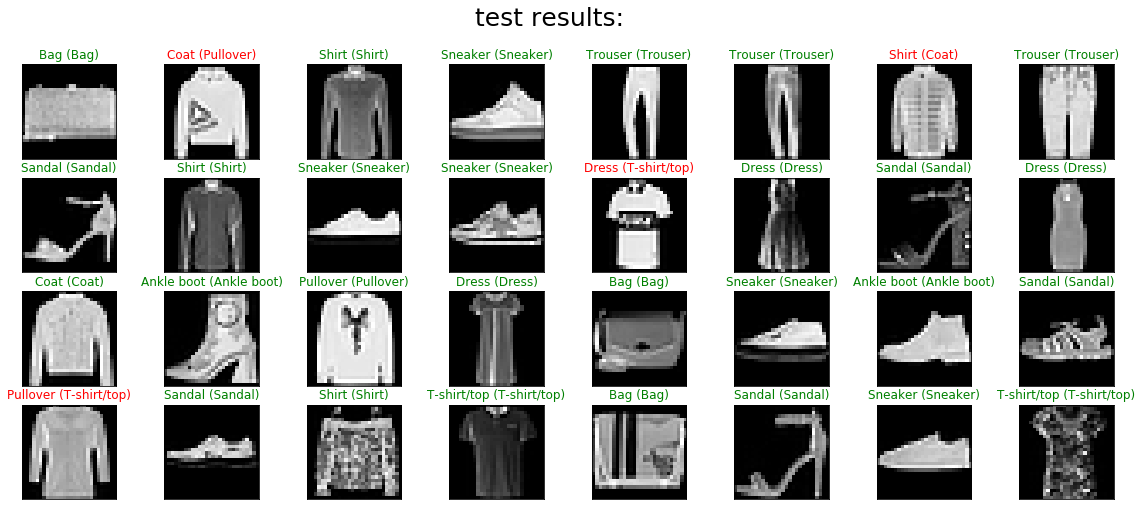

In [0]:
## Load the best model:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)
 
print('Test accuracy: %.2f%%' %(100*score[1]))
 

## Get test predictions:

## Visualise some results:
visualize_model_predictions(model, x_test, y_test, 'test')

### Confusion Matrix

Confusion matrix, without normalization
Normalized confusion matrix


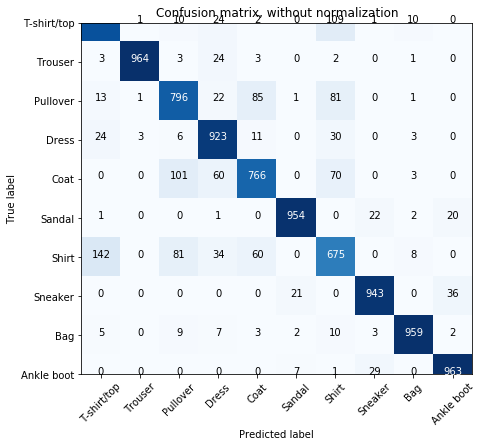

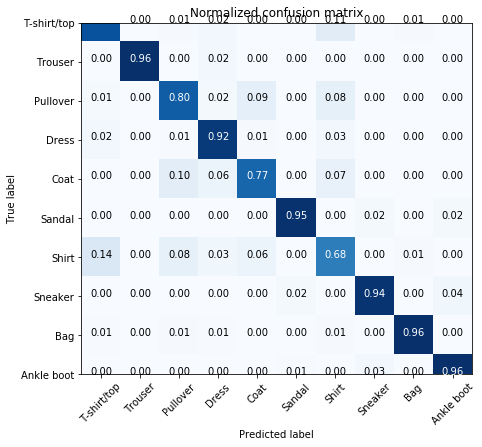

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
 
 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()
 
 
y_pred = model.predict(x_test)
y_pred_integers = np.argmax(y_pred, axis = 1)
y_test_integers = np.argmax(y_test, axis = 1)
 
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_integers, y_pred_integers)
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
fs = 7
plt.figure(figsize=(fs,fs))
plot_confusion_matrix(cnf_matrix, classes=dataset_labels,
                      title='Confusion matrix, without normalization')
 
# Plot normalized confusion matrix
plt.figure(figsize=(fs,fs))
plot_confusion_matrix(cnf_matrix, classes=dataset_labels, normalize=True,
                      title='Normalized confusion matrix')
 
plt.show()

## 2.2 Let's make our model Deeper! 
Add two extra hidden layers to start with.
Explore the effects of adding more depth/width to your network, what happens to the number of trainable parameters?
What about training speed, test-accuracy, ... Notice that there usually is a clear tradeoff between training-time and model performance.

In [0]:
model = tf.keras.Sequential()

# Define the model architecture:
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(784, activation = 'relu'))
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dense(56, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
 
# Take a look at the model summary
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 56)                3640      
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [0]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train,
         y_train,
         batch_size=48,
         epochs=10,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
53808/54000 [============================>.] - ETA: 0s - loss: 0.1982 - acc: 0.9252
Epoch 00001: val_loss improved from inf to 0.34136, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 6s 115us/sample - loss: 0.1983 - acc: 0.9252 - val_loss: 0.3414 - val_acc: 0.8905
Epoch 2/10
53952/54000 [============================>.] - ETA: 0s - loss: 0.1893 - acc: 0.9285
Epoch 00002: val_loss did not improve from 0.34136
54000/54000 [==============================] - 6s 114us/sample - loss: 0.1893 - acc: 0.9285 - val_loss: 0.3422 - val_acc: 0.8925
Epoch 3/10
53472/54000 [============================>.] - ETA: 0s - loss: 0.1840 - acc: 0.9309
Epoch 00003: val_loss improved from 0.34136 to 0.33194, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 6s 111us/sample - loss: 0.1840 - acc: 0.9308 - val_loss: 0.3319 - val_acc: 0.8935
Epoch 4/10
53568/54000 [================

In [0]:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)
 
print('Test accuracy: %.2f%%' %(100*score[1]))

Test accuracy: 89.00%


# Adding callbacks
Because we just made our model a lot deeper, it will have to train longer in order to use its full potential!
But obviously, we don't want to keep training too long or we'll overfit.
To get more info during training we'll add two extra callbacks to the model.fit() method that:
1. Stop the model training loop if the validation loss keeps dropping consistently (eg 10 times in a row) (This is a default callback, available in Keras)
2. Periodically visualise the validation error while training (This is a custom callback function you will have to create yourself)

You can find more documentation here: https://keras.io/callbacks/ (For the custom callback, scroll down to "Create a callback" section)

In [0]:
class plot_train_progress(tf.keras.callbacks.Callback):
    def __init__(self, plot_every_n_epochs = 5, plot_fraction = 0.9):
        self.plot_frequency = plot_every_n_epochs
        self.plot_fraction = plot_fraction #Plot only the most recent values
        
    def on_train_begin(self, logs={}):
        self.train_losses = []
        self.val_losses = []
 
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.plot_frequency == 0:
            nr_values_to_plot = int(self.plot_fraction * len(self.train_losses))
            if nr_values_to_plot > 1:
                t = list(range(nr_values_to_plot))
                plt.plot(t, self.train_losses[-nr_values_to_plot:], 'b')
                plt.plot(t, self.val_losses[-nr_values_to_plot:], 'g')
                plt.xlabel('# Batches')
                plt.ylabel('Validation Loss')
                #plt.savefig('train_progress.jpg')
                plt.show()
 
    def on_batch_end(self, batch, logs={}):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
earlyStopping= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 0, save_best_only=True)
callbacks_list = [checkpointer, plot_train_progress(5, .9), earlyStopping]


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/45
53376/54000 [============================>.] - ETA: 0s

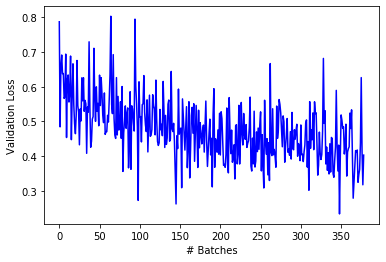

54000/54000 [==============================] - 3s 47us/sample - loss: 0.5355 - acc: 0.8117 - val_loss: 0.3963 - val_acc: 0.8535
Epoch 2/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.3812 - acc: 0.8623 - val_loss: 0.3775 - val_acc: 0.8648
Epoch 3/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.3371 - acc: 0.8776 - val_loss: 0.3440 - val_acc: 0.8730
Epoch 4/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.3106 - acc: 0.8848 - val_loss: 0.3409 - val_acc: 0.8777
Epoch 5/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.2899 - acc: 0.8929 - val_loss: 0.3311 - val_acc: 0.8793
Epoch 6/45
53760/54000 [============================>.] - ETA: 0s - loss: 0.2772 - acc: 0.8983

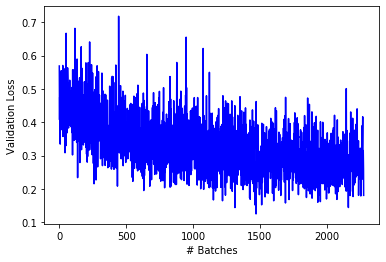

54000/54000 [==============================] - 2s 40us/sample - loss: 0.2770 - acc: 0.8983 - val_loss: 0.3365 - val_acc: 0.8815
Epoch 7/45
54000/54000 [==============================] - 2s 37us/sample - loss: 0.2623 - acc: 0.9022 - val_loss: 0.3140 - val_acc: 0.8882
Epoch 8/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.2507 - acc: 0.9053 - val_loss: 0.3318 - val_acc: 0.8867
Epoch 9/45
54000/54000 [==============================] - 2s 34us/sample - loss: 0.2457 - acc: 0.9067 - val_loss: 0.3409 - val_acc: 0.8833
Epoch 10/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.2320 - acc: 0.9126 - val_loss: 0.3152 - val_acc: 0.8867
Epoch 11/45
53120/54000 [============================>.] - ETA: 0s - loss: 0.2249 - acc: 0.9157

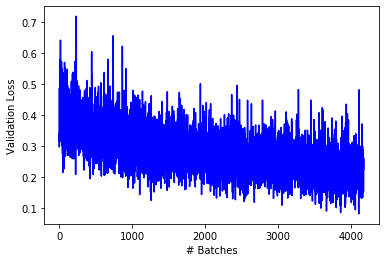

54000/54000 [==============================] - 2s 39us/sample - loss: 0.2251 - acc: 0.9156 - val_loss: 0.3150 - val_acc: 0.8908
Epoch 12/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.2162 - acc: 0.9190 - val_loss: 0.3245 - val_acc: 0.8872
Epoch 13/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.2056 - acc: 0.9220 - val_loss: 0.3116 - val_acc: 0.8902
Epoch 14/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1993 - acc: 0.9253 - val_loss: 0.3216 - val_acc: 0.8935
Epoch 15/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1945 - acc: 0.9262 - val_loss: 0.3471 - val_acc: 0.8853
Epoch 16/45
52608/54000 [============================>.] - ETA: 0s - loss: 0.1878 - acc: 0.9294

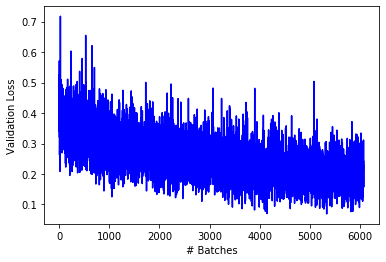

54000/54000 [==============================] - 2s 40us/sample - loss: 0.1886 - acc: 0.9291 - val_loss: 0.3405 - val_acc: 0.8845
Epoch 17/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1809 - acc: 0.9307 - val_loss: 0.3310 - val_acc: 0.8937
Epoch 18/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.1753 - acc: 0.9338 - val_loss: 0.3383 - val_acc: 0.8865
Epoch 19/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1702 - acc: 0.9375 - val_loss: 0.3805 - val_acc: 0.8842
Epoch 20/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1634 - acc: 0.9386 - val_loss: 0.3364 - val_acc: 0.8905
Epoch 21/45
53248/54000 [============================>.] - ETA: 0s - loss: 0.1569 - acc: 0.9405

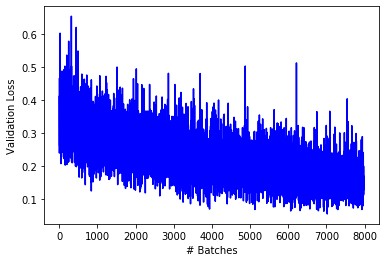

54000/54000 [==============================] - 2s 40us/sample - loss: 0.1569 - acc: 0.9405 - val_loss: 0.3674 - val_acc: 0.8920
Epoch 22/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1518 - acc: 0.9422 - val_loss: 0.4005 - val_acc: 0.8892
Epoch 23/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.1483 - acc: 0.9438 - val_loss: 0.3672 - val_acc: 0.8910
Epoch 24/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.1443 - acc: 0.9456 - val_loss: 0.3525 - val_acc: 0.8937
Epoch 25/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1425 - acc: 0.9454 - val_loss: 0.3834 - val_acc: 0.8868
Epoch 26/45
52992/54000 [============================>.] - ETA: 0s - loss: 0.1333 - acc: 0.9485

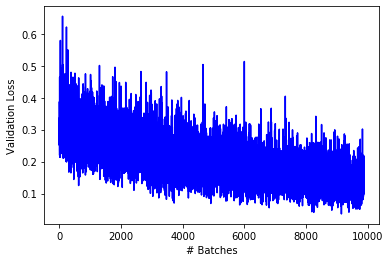

54000/54000 [==============================] - 2s 40us/sample - loss: 0.1336 - acc: 0.9485 - val_loss: 0.3745 - val_acc: 0.8928
Epoch 27/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1302 - acc: 0.9499 - val_loss: 0.3749 - val_acc: 0.8935
Epoch 28/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.1262 - acc: 0.9522 - val_loss: 0.3729 - val_acc: 0.8957
Epoch 29/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1228 - acc: 0.9539 - val_loss: 0.3905 - val_acc: 0.8917
Epoch 30/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1187 - acc: 0.9548 - val_loss: 0.4228 - val_acc: 0.8937
Epoch 31/45
53248/54000 [============================>.] - ETA: 0s - loss: 0.1157 - acc: 0.9546

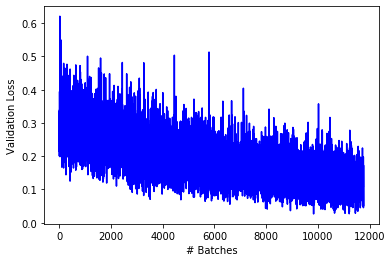

54000/54000 [==============================] - 2s 41us/sample - loss: 0.1155 - acc: 0.9547 - val_loss: 0.4189 - val_acc: 0.8913
Epoch 32/45
54000/54000 [==============================] - 2s 36us/sample - loss: 0.1153 - acc: 0.9569 - val_loss: 0.3905 - val_acc: 0.8912
Epoch 33/45
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1064 - acc: 0.9592 - val_loss: 0.4235 - val_acc: 0.8928
Epoch 00033: early stopping


In [0]:
model = tf.keras.Sequential()
 
# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
 
# Take a look at the model summary
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
model.fit(x_train,
         y_train,
         batch_size=128,
         epochs=45,
         validation_data=(x_valid, y_valid),
         callbacks=callbacks_list)


## Evaluate the model

In [0]:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)

print('Test accuracy: %.2f%%' %(100*score[1]))

Test accuracy: 88.61%


**Extra:** To experiment and get some intuition as to why making the network deeper makes it easier to fit the data, you can experiment with this amazing in-browser tool: https://playground.tensorflow.org/

## 2.2 Convolutions 
### Lets add in some of the big guns in Computer Vision: Convolutions!

Notice that up until now, we've always started our network with a Flatten() operation that basically throws away all the spatial dependency information in our image. Time to change that!

Chain two Conv2D layers in the beginning of the network (remove the Flatten operation) and follow each one with a MaxPooling2D layer to downscale the resolution of the hidden representations. Finally add some normal FC layers to map the convolutional features to the output classes. (You will need to re-add a Flatten() operation for this).
Play around with different architectures and keep track of the following variables:
- Total number of trainable parameters in the network
- Network depth (how many non-linear layers do I have that transform the data from pixel-space to label-space?)
- Training time per epoch
- Final accuracy after training for N epochs

You can find the documentation for the Conv2D layers here: https://keras.io/layers/convolutional/

**Extra question:** What does the MaxPooling2D operation do exactly? Do we lose any information in this step? What is good/bad about that?

In [0]:
model = tf.keras.Sequential()

# Define the model:
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
 
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_23 (Dense)             (None, 64)              

Train on 54000 samples, validate on 6000 samples
Epoch 1/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9965
Epoch 00001: val_loss improved from inf to 0.78218, saving model to model.weights.best.hdf5


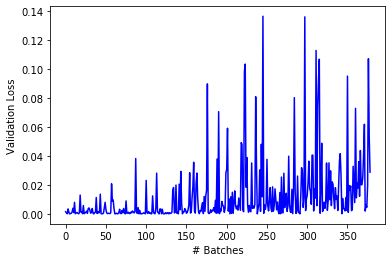

54000/54000 [==============================] - 4s 81us/sample - loss: 0.0113 - acc: 0.9964 - val_loss: 0.7822 - val_acc: 0.9082
Epoch 2/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9942
Epoch 00002: val_loss improved from 0.78218 to 0.77443, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 4s 73us/sample - loss: 0.0180 - acc: 0.9942 - val_loss: 0.7744 - val_acc: 0.9102
Epoch 3/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.0139 - acc: 0.9954
Epoch 00003: val_loss improved from 0.77443 to 0.76321, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 4s 72us/sample - loss: 0.0139 - acc: 0.9954 - val_loss: 0.7632 - val_acc: 0.9097
Epoch 4/150
53248/54000 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9970
Epoch 00004: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 70us/sample - loss: 0.0089 - acc: 0

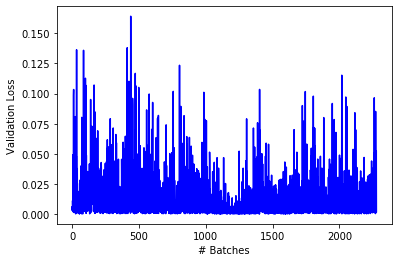

54000/54000 [==============================] - 4s 74us/sample - loss: 0.0117 - acc: 0.9960 - val_loss: 0.8661 - val_acc: 0.9055
Epoch 7/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.9978
Epoch 00007: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 71us/sample - loss: 0.0072 - acc: 0.9978 - val_loss: 0.8529 - val_acc: 0.9102
Epoch 8/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9961
Epoch 00008: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 70us/sample - loss: 0.0125 - acc: 0.9961 - val_loss: 0.7980 - val_acc: 0.9068
Epoch 9/150
53888/54000 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9958
Epoch 00009: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 72us/sample - loss: 0.0127 - acc: 0.9957 - val_loss: 0.8000 - val_acc: 0.9112
Epoch 10/150
53632/54000 [=====================

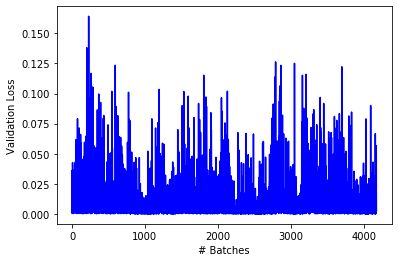

54000/54000 [==============================] - 4s 73us/sample - loss: 0.0078 - acc: 0.9974 - val_loss: 0.8583 - val_acc: 0.9122
Epoch 12/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9964
Epoch 00012: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 70us/sample - loss: 0.0106 - acc: 0.9963 - val_loss: 0.8224 - val_acc: 0.9113
Epoch 13/150
53376/54000 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9970
Epoch 00013: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 70us/sample - loss: 0.0092 - acc: 0.9970 - val_loss: 0.8067 - val_acc: 0.9133
Epoch 14/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9957
Epoch 00014: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 69us/sample - loss: 0.0129 - acc: 0.9957 - val_loss: 0.8334 - val_acc: 0.9110
Epoch 15/150
53760/54000 [==================

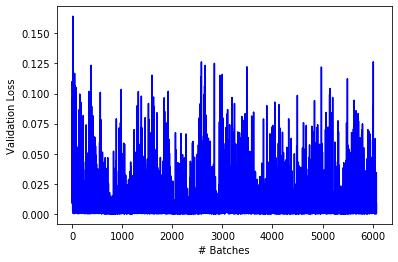

54000/54000 [==============================] - 4s 74us/sample - loss: 0.0122 - acc: 0.9959 - val_loss: 0.8462 - val_acc: 0.9118
Epoch 17/150
53888/54000 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9969
Epoch 00017: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 70us/sample - loss: 0.0089 - acc: 0.9969 - val_loss: 0.8266 - val_acc: 0.9130
Epoch 18/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9975
Epoch 00018: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 70us/sample - loss: 0.0081 - acc: 0.9974 - val_loss: 0.8257 - val_acc: 0.9085
Epoch 19/150
53376/54000 [============================>.] - ETA: 0s - loss: 0.0103 - acc: 0.9964
Epoch 00019: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 69us/sample - loss: 0.0102 - acc: 0.9965 - val_loss: 0.8031 - val_acc: 0.9105
Epoch 20/150
53248/54000 [==================

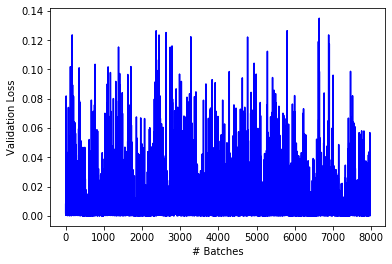

54000/54000 [==============================] - 4s 75us/sample - loss: 0.0072 - acc: 0.9975 - val_loss: 0.8576 - val_acc: 0.9132
Epoch 22/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9960
Epoch 00022: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 69us/sample - loss: 0.0126 - acc: 0.9959 - val_loss: 0.8374 - val_acc: 0.9095
Epoch 23/150
53248/54000 [============================>.] - ETA: 0s - loss: 0.0153 - acc: 0.9950
Epoch 00023: val_loss did not improve from 0.76321
54000/54000 [==============================] - 4s 70us/sample - loss: 0.0153 - acc: 0.9950 - val_loss: 0.8696 - val_acc: 0.9060
Epoch 00023: early stopping


In [0]:
 
earlyStopping= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
callbacks_list = [checkpointer, plot_train_progress(5, .9), earlyStopping]
 
model.fit(x_train,
         y_train,
         batch_size=128,
         epochs=150,
         validation_data=(x_valid, y_valid),
         callbacks=callbacks_list)


## Evaluate model

Test accuracy: 90.48%
Train accuracy: 99.67%


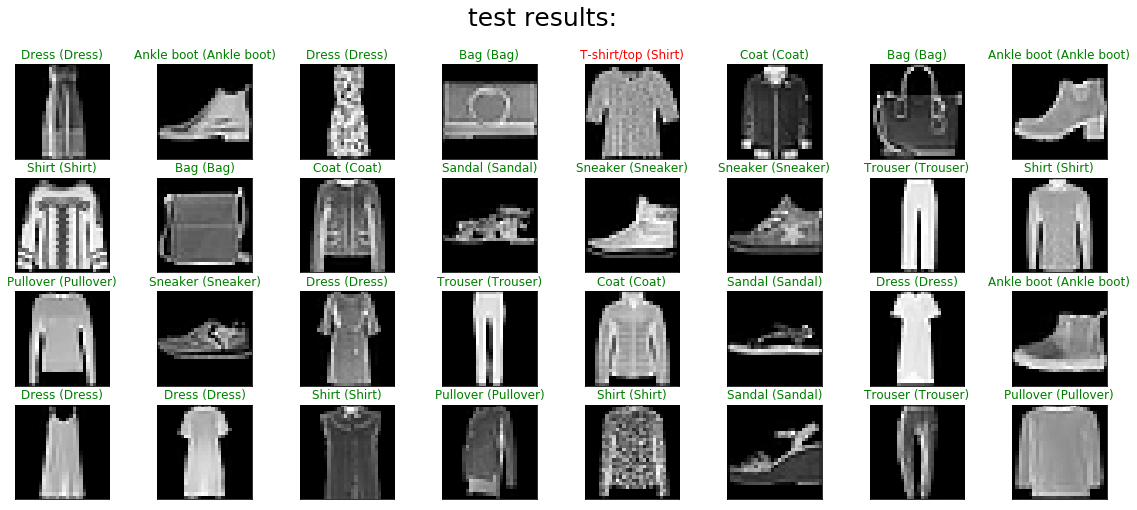

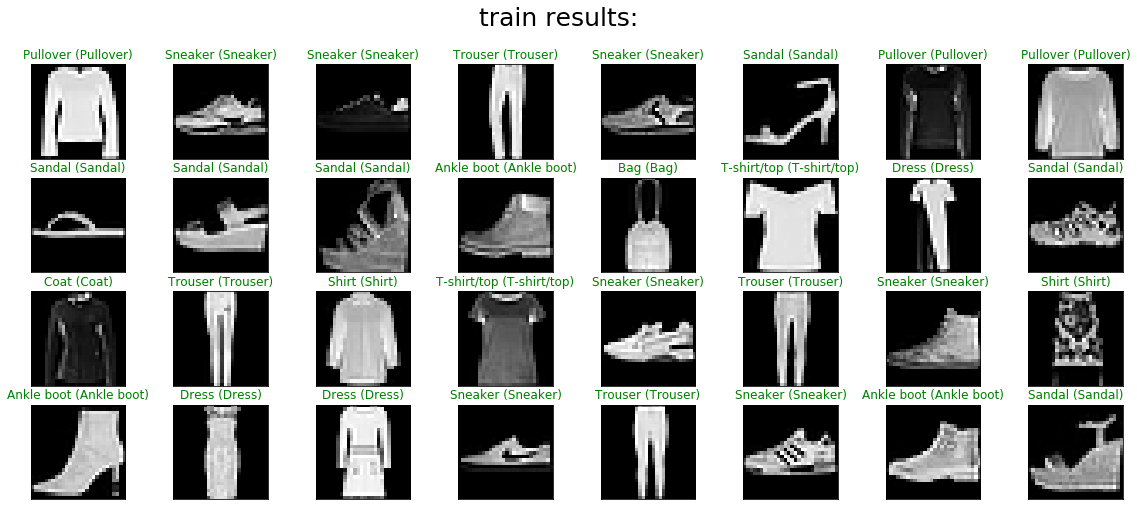

In [0]:
visualize_model_predictions(model, x_test, y_test, 'test')
visualize_model_predictions(model, x_train, y_train, 'train')
 
#Compute & compare train and test accuracies:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: %.2f%%' %(100*score[1]))
 
score = model.evaluate(x_train, y_train, verbose=0)
print('Train accuracy: %.2f%%' %(100*score[1]))

In [0]:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)

print('Test accuracy: %.2f%%' %(100*score[1]))

Test accuracy: 90.28%


**Extra**:
Run the visualize_model_predictions() function both on some examples from the training data and the test data, do you notice any differences? Is there an overall difference between the accuracy on the Train-set vs the Test-set? What is going on?

### Best Model

Test accuracy: 90.73%
Train accuracy: 99.75%


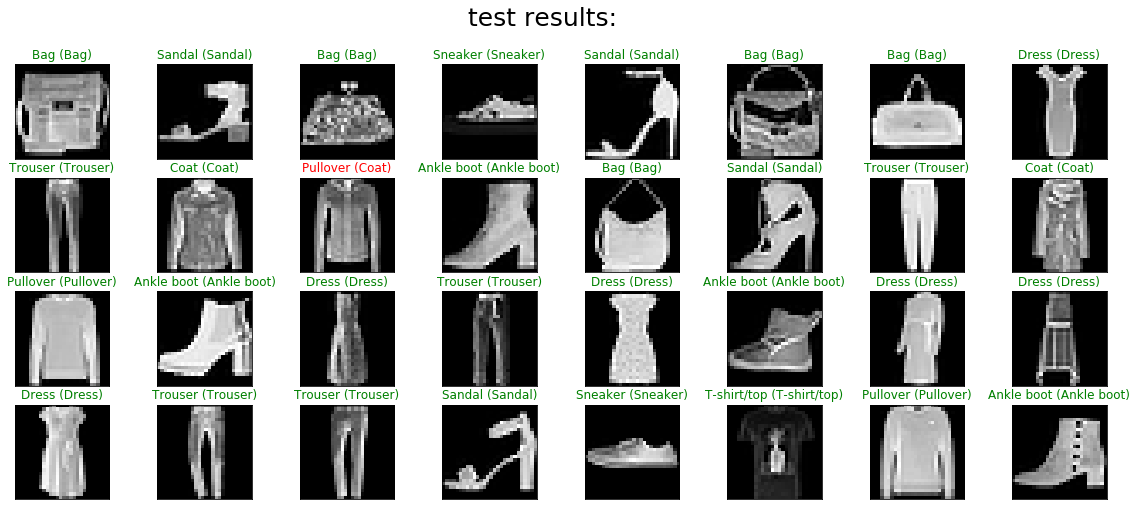

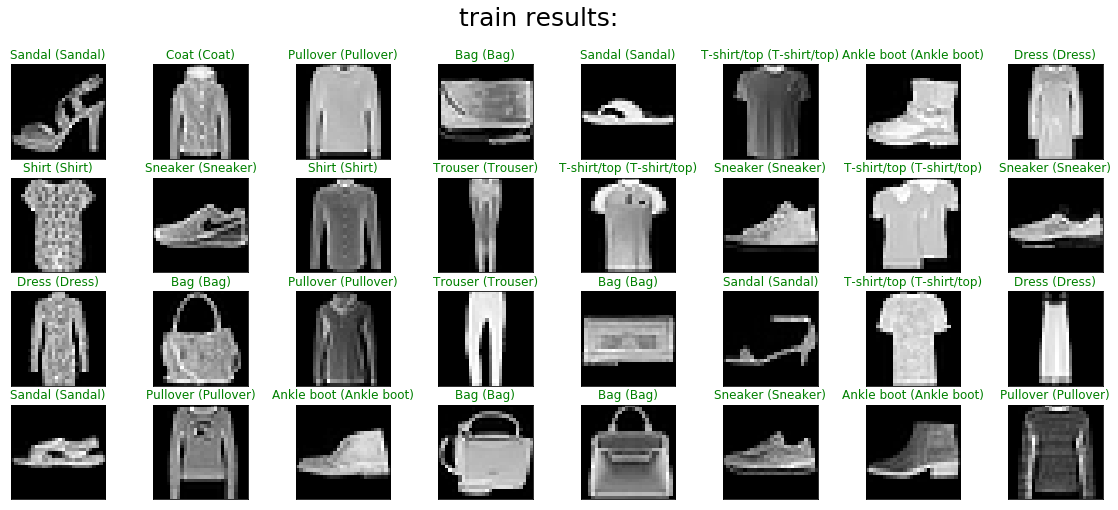

In [0]:
model.load_weights('model.weights.best.hdf5')
visualize_model_predictions(model, x_test, y_test, 'test')
visualize_model_predictions(model, x_train, y_train, 'train')
 
#Compute & compare train and test accuracies:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: %.2f%%' %(100*score[1]))
 
score = model.evaluate(x_train, y_train, verbose=0)
print('Train accuracy: %.2f%%' %(100*score[1]))

# 3 Regularization

Our model currently has a lot of degrees of freedom (it has a LOT of trainable parameters and can therefore fit almost any function if we just keep training for long enough). This means our network is also prone to overfitting. 

In this section, let's add dropout layers between the main parts of our network to avoid overfitting.
What is a good dropout rate?

**Extra:** To get an idea of the degree to which these networks can overfit take a look at this amazing paper which shows that a large enough CNN can basically memorize a very large, random dataset: https://arxiv.org/abs/1611.03530

**Extra:** Also try to add an L2 Regularization penalty to every layer in your network. What is a good setting of the multiplier constant? (see https://keras.io/regularizers/)

In [0]:
from keras import regularizers

In [0]:
model = tf.keras.Sequential()
beta = 0.005
dropout_rate = 0.6

# Define the model:
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
 
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
 
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l2(beta)))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = regularizers.l2(beta)))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer = regularizers.l2(beta)))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = regularizers.l2(beta)))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


# Take a look at the model summary
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_13 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)             

Train on 54000 samples, validate on 6000 samples
Epoch 1/150
53760/54000 [============================>.] - ETA: 0s - loss: 2.0691 - acc: 0.3600
Epoch 00001: val_loss improved from inf to 1.07644, saving model to model.weights.best.hdf5


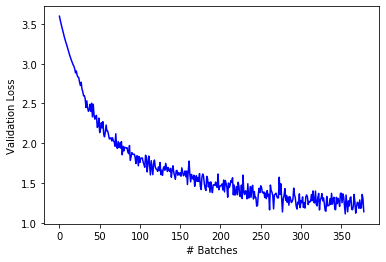

54000/54000 [==============================] - 8s 139us/sample - loss: 2.0654 - acc: 0.3609 - val_loss: 1.0764 - val_acc: 0.6592
Epoch 2/150
53888/54000 [============================>.] - ETA: 0s - loss: 1.0887 - acc: 0.6575
Epoch 00002: val_loss improved from 1.07644 to 0.79487, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 93us/sample - loss: 1.0885 - acc: 0.6576 - val_loss: 0.7949 - val_acc: 0.7950
Epoch 3/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.8990 - acc: 0.7593
Epoch 00003: val_loss improved from 0.79487 to 0.69736, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 93us/sample - loss: 0.8986 - acc: 0.7593 - val_loss: 0.6974 - val_acc: 0.8147
Epoch 4/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.8163 - acc: 0.7874
Epoch 00004: val_loss improved from 0.69736 to 0.66519, saving model to model.weights.best.hdf5
54000/54000 [==========================

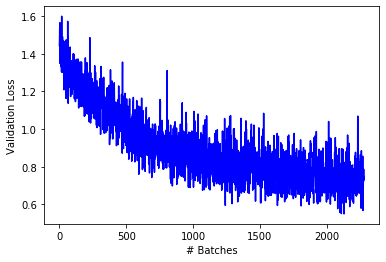

54000/54000 [==============================] - 5s 97us/sample - loss: 0.7417 - acc: 0.8112 - val_loss: 0.6069 - val_acc: 0.8400
Epoch 7/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.7143 - acc: 0.8261
Epoch 00007: val_loss did not improve from 0.60685
54000/54000 [==============================] - 5s 92us/sample - loss: 0.7141 - acc: 0.8261 - val_loss: 0.6115 - val_acc: 0.8515
Epoch 8/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.6935 - acc: 0.8400
Epoch 00008: val_loss improved from 0.60685 to 0.59255, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 92us/sample - loss: 0.6931 - acc: 0.8400 - val_loss: 0.5926 - val_acc: 0.8495
Epoch 9/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.6785 - acc: 0.8471
Epoch 00009: val_loss improved from 0.59255 to 0.57119, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 92us/sample - loss: 0.6784 - acc: 0

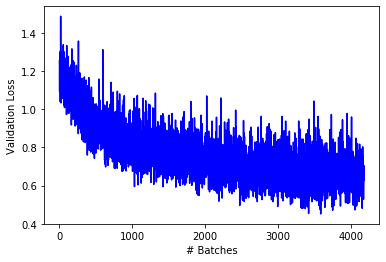

54000/54000 [==============================] - 5s 97us/sample - loss: 0.6530 - acc: 0.8573 - val_loss: 0.5527 - val_acc: 0.8762
Epoch 12/150
53888/54000 [============================>.] - ETA: 0s - loss: 0.6393 - acc: 0.8597
Epoch 00012: val_loss improved from 0.55270 to 0.53092, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 94us/sample - loss: 0.6395 - acc: 0.8597 - val_loss: 0.5309 - val_acc: 0.8833
Epoch 13/150
53376/54000 [============================>.] - ETA: 0s - loss: 0.6261 - acc: 0.8651
Epoch 00013: val_loss did not improve from 0.53092
54000/54000 [==============================] - 5s 90us/sample - loss: 0.6259 - acc: 0.8650 - val_loss: 0.5421 - val_acc: 0.8783
Epoch 14/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.6203 - acc: 0.8673
Epoch 00014: val_loss did not improve from 0.53092
54000/54000 [==============================] - 5s 90us/sample - loss: 0.6202 - acc: 0.8672 - val_loss: 0.5347 - val_acc: 0.8812

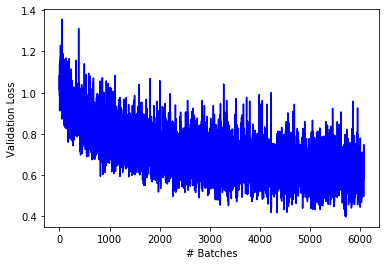

54000/54000 [==============================] - 5s 95us/sample - loss: 0.6096 - acc: 0.8719 - val_loss: 0.5322 - val_acc: 0.8817
Epoch 17/150
53888/54000 [============================>.] - ETA: 0s - loss: 0.5934 - acc: 0.8751
Epoch 00017: val_loss improved from 0.53092 to 0.52541, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 91us/sample - loss: 0.5936 - acc: 0.8750 - val_loss: 0.5254 - val_acc: 0.8885
Epoch 18/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.5948 - acc: 0.8759
Epoch 00018: val_loss improved from 0.52541 to 0.50471, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 92us/sample - loss: 0.5946 - acc: 0.8760 - val_loss: 0.5047 - val_acc: 0.8887
Epoch 19/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.5907 - acc: 0.8774
Epoch 00019: val_loss improved from 0.50471 to 0.50403, saving model to model.weights.best.hdf5
54000/54000 [========================

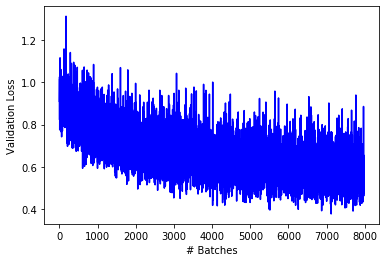

54000/54000 [==============================] - 5s 95us/sample - loss: 0.5777 - acc: 0.8797 - val_loss: 0.5106 - val_acc: 0.8915
Epoch 22/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.5648 - acc: 0.8835
Epoch 00022: val_loss improved from 0.50403 to 0.49620, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 91us/sample - loss: 0.5648 - acc: 0.8834 - val_loss: 0.4962 - val_acc: 0.8932
Epoch 23/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.5671 - acc: 0.8837
Epoch 00023: val_loss did not improve from 0.49620
54000/54000 [==============================] - 5s 90us/sample - loss: 0.5677 - acc: 0.8836 - val_loss: 0.5190 - val_acc: 0.8930
Epoch 24/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.5670 - acc: 0.8859
Epoch 00024: val_loss did not improve from 0.49620
54000/54000 [==============================] - 5s 90us/sample - loss: 0.5668 - acc: 0.8858 - val_loss: 0.5172 - val_acc: 0.8958

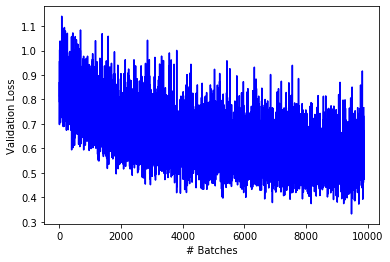

54000/54000 [==============================] - 5s 96us/sample - loss: 0.5622 - acc: 0.8864 - val_loss: 0.5025 - val_acc: 0.9013
Epoch 27/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.5497 - acc: 0.8892
Epoch 00027: val_loss did not improve from 0.49153
54000/54000 [==============================] - 5s 90us/sample - loss: 0.5499 - acc: 0.8892 - val_loss: 0.4983 - val_acc: 0.8978
Epoch 28/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.5392 - acc: 0.8923
Epoch 00028: val_loss did not improve from 0.49153
54000/54000 [==============================] - 5s 89us/sample - loss: 0.5389 - acc: 0.8923 - val_loss: 0.4970 - val_acc: 0.8963
Epoch 29/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.5281 - acc: 0.8941
Epoch 00029: val_loss improved from 0.49153 to 0.48598, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 92us/sample - loss: 0.5278 - acc: 0.8941 - val_loss: 0.4860 - val_acc: 0.9010

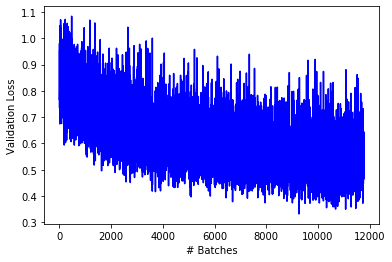

54000/54000 [==============================] - 5s 95us/sample - loss: 0.5352 - acc: 0.8943 - val_loss: 0.4923 - val_acc: 0.9012
Epoch 32/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.5334 - acc: 0.8955
Epoch 00032: val_loss did not improve from 0.48598
54000/54000 [==============================] - 5s 89us/sample - loss: 0.5331 - acc: 0.8955 - val_loss: 0.4959 - val_acc: 0.9007
Epoch 33/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.5305 - acc: 0.8968
Epoch 00033: val_loss did not improve from 0.48598
54000/54000 [==============================] - 5s 90us/sample - loss: 0.5303 - acc: 0.8969 - val_loss: 0.5006 - val_acc: 0.8990
Epoch 34/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.5239 - acc: 0.8987
Epoch 00034: val_loss did not improve from 0.48598
54000/54000 [==============================] - 5s 91us/sample - loss: 0.5240 - acc: 0.8987 - val_loss: 0.4901 - val_acc: 0.8950
Epoch 35/150
53888/54000 [==================

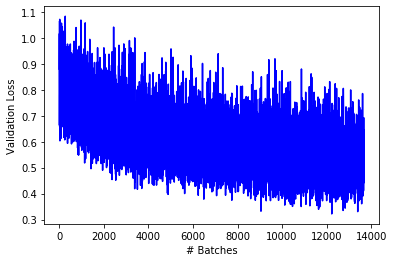

54000/54000 [==============================] - 5s 96us/sample - loss: 0.5165 - acc: 0.8994 - val_loss: 0.5152 - val_acc: 0.8993
Epoch 37/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.5140 - acc: 0.8995
Epoch 00037: val_loss improved from 0.48598 to 0.48273, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 94us/sample - loss: 0.5138 - acc: 0.8995 - val_loss: 0.4827 - val_acc: 0.9040
Epoch 38/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.5098 - acc: 0.9022
Epoch 00038: val_loss improved from 0.48273 to 0.48212, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 93us/sample - loss: 0.5098 - acc: 0.9022 - val_loss: 0.4821 - val_acc: 0.9005
Epoch 39/150
53888/54000 [============================>.] - ETA: 0s - loss: 0.5128 - acc: 0.9003
Epoch 00039: val_loss did not improve from 0.48212
54000/54000 [==============================] - 5s 90us/sample - loss: 0.5127 - acc

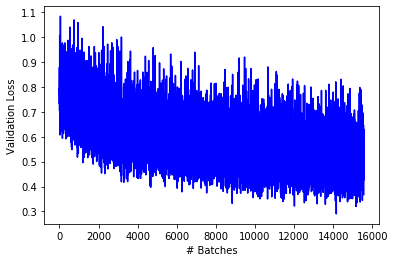

54000/54000 [==============================] - 5s 95us/sample - loss: 0.5062 - acc: 0.9031 - val_loss: 0.4745 - val_acc: 0.9073
Epoch 42/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.5012 - acc: 0.9041
Epoch 00042: val_loss did not improve from 0.47435
54000/54000 [==============================] - 5s 90us/sample - loss: 0.5012 - acc: 0.9042 - val_loss: 0.4913 - val_acc: 0.9053
Epoch 43/150
53888/54000 [============================>.] - ETA: 0s - loss: 0.5001 - acc: 0.9070
Epoch 00043: val_loss improved from 0.47435 to 0.47248, saving model to model.weights.best.hdf5
54000/54000 [==============================] - 5s 91us/sample - loss: 0.5000 - acc: 0.9071 - val_loss: 0.4725 - val_acc: 0.9057
Epoch 44/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.4896 - acc: 0.9069
Epoch 00044: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 90us/sample - loss: 0.4896 - acc: 0.9068 - val_loss: 0.4783 - val_acc: 0.9045

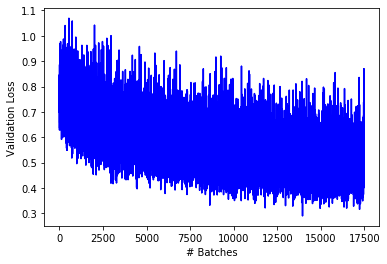

54000/54000 [==============================] - 5s 96us/sample - loss: 0.4903 - acc: 0.9070 - val_loss: 0.5078 - val_acc: 0.9005
Epoch 47/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.4909 - acc: 0.9084
Epoch 00047: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 90us/sample - loss: 0.4910 - acc: 0.9084 - val_loss: 0.4904 - val_acc: 0.9038
Epoch 48/150
53888/54000 [============================>.] - ETA: 0s - loss: 0.4910 - acc: 0.9110
Epoch 00048: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 90us/sample - loss: 0.4908 - acc: 0.9110 - val_loss: 0.4857 - val_acc: 0.9035
Epoch 49/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.4858 - acc: 0.9100
Epoch 00049: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 90us/sample - loss: 0.4856 - acc: 0.9102 - val_loss: 0.5056 - val_acc: 0.9020
Epoch 50/150
53760/54000 [==================

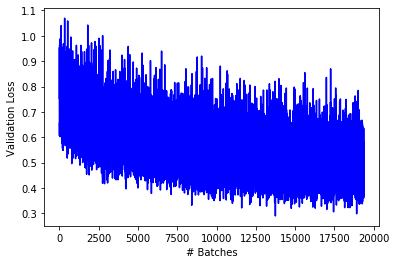

54000/54000 [==============================] - 5s 95us/sample - loss: 0.4849 - acc: 0.9098 - val_loss: 0.4995 - val_acc: 0.9013
Epoch 52/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.4887 - acc: 0.9110
Epoch 00052: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 90us/sample - loss: 0.4884 - acc: 0.9111 - val_loss: 0.4833 - val_acc: 0.9083
Epoch 53/150
53760/54000 [============================>.] - ETA: 0s - loss: 0.4696 - acc: 0.9146
Epoch 00053: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 90us/sample - loss: 0.4703 - acc: 0.9145 - val_loss: 0.4729 - val_acc: 0.9093
Epoch 54/150
53888/54000 [============================>.] - ETA: 0s - loss: 0.4774 - acc: 0.9155
Epoch 00054: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 89us/sample - loss: 0.4772 - acc: 0.9154 - val_loss: 0.4883 - val_acc: 0.9088
Epoch 55/150
53888/54000 [==================

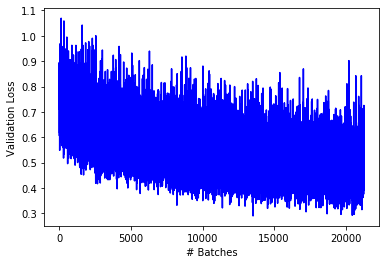

54000/54000 [==============================] - 5s 95us/sample - loss: 0.4686 - acc: 0.9160 - val_loss: 0.4953 - val_acc: 0.9028
Epoch 57/150
53504/54000 [============================>.] - ETA: 0s - loss: 0.4564 - acc: 0.9172
Epoch 00057: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 90us/sample - loss: 0.4562 - acc: 0.9170 - val_loss: 0.4925 - val_acc: 0.9042
Epoch 58/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.4537 - acc: 0.9184
Epoch 00058: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 90us/sample - loss: 0.4538 - acc: 0.9183 - val_loss: 0.4878 - val_acc: 0.9087
Epoch 59/150
53888/54000 [============================>.] - ETA: 0s - loss: 0.4660 - acc: 0.9178
Epoch 00059: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 89us/sample - loss: 0.4660 - acc: 0.9178 - val_loss: 0.4760 - val_acc: 0.9023
Epoch 60/150
53632/54000 [==================

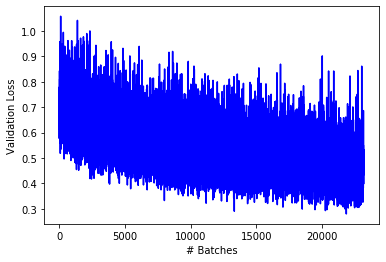

54000/54000 [==============================] - 5s 95us/sample - loss: 0.4672 - acc: 0.9183 - val_loss: 0.5083 - val_acc: 0.9060
Epoch 62/150
53888/54000 [============================>.] - ETA: 0s - loss: 0.4593 - acc: 0.9196
Epoch 00062: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 89us/sample - loss: 0.4593 - acc: 0.9196 - val_loss: 0.4776 - val_acc: 0.9077
Epoch 63/150
53632/54000 [============================>.] - ETA: 0s - loss: 0.4547 - acc: 0.9202
Epoch 00063: val_loss did not improve from 0.47248
54000/54000 [==============================] - 5s 90us/sample - loss: 0.4546 - acc: 0.9202 - val_loss: 0.4836 - val_acc: 0.9100
Epoch 00063: early stopping


In [0]:
earlyStopping= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
callbacks_list = [checkpointer, plot_train_progress(5, .9), earlyStopping]
 
model.fit(x_train,
         y_train,
         batch_size=128,
         epochs=150,
         validation_data=(x_valid, y_valid),
         callbacks=callbacks_list)


## Evaluate model:

Test accuracy: 90.36%
Train accuracy: 94.35%


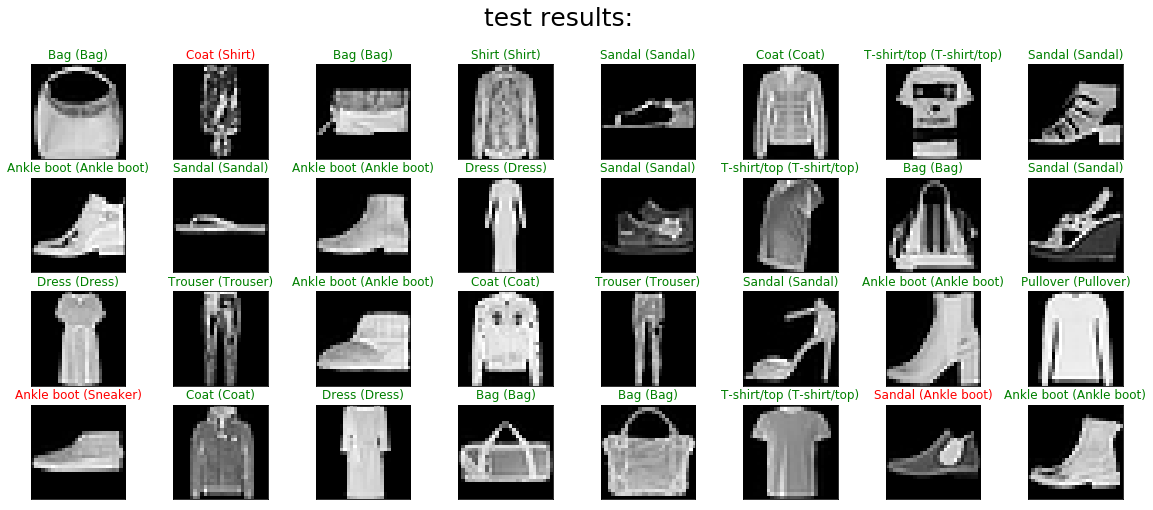

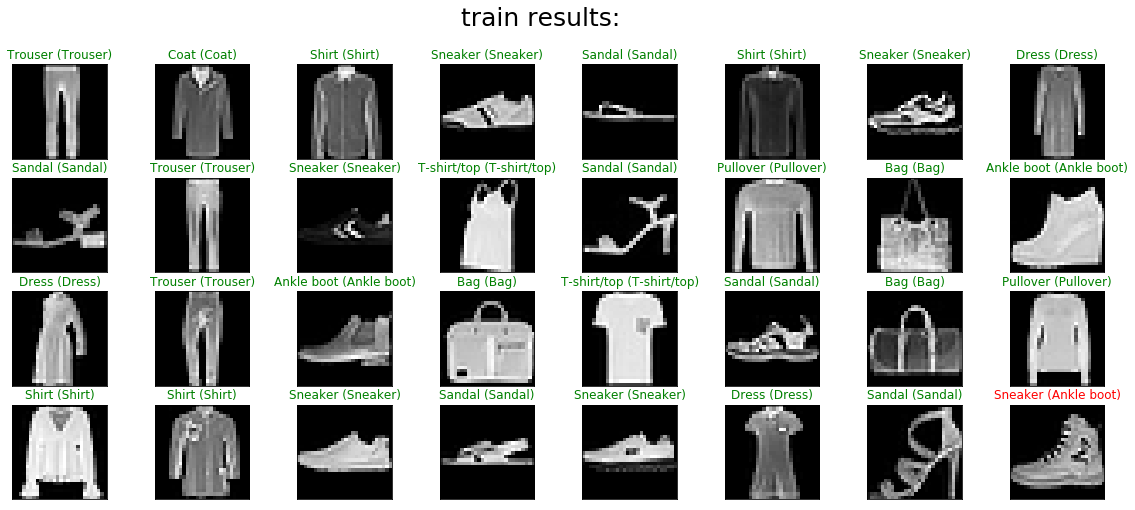

In [0]:
visualize_model_predictions(model, x_test, y_test, 'test')
visualize_model_predictions(model, x_train, y_train, 'train')
 
#Compute & compare train and test accuracies:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: %.2f%%' %(100*score[1]))
 
score = model.evaluate(x_train, y_train, verbose=0)
print('Train accuracy: %.2f%%' %(100*score[1]))

### Best Model

Test accuracy: 90.19%
Train accuracy: 92.80%


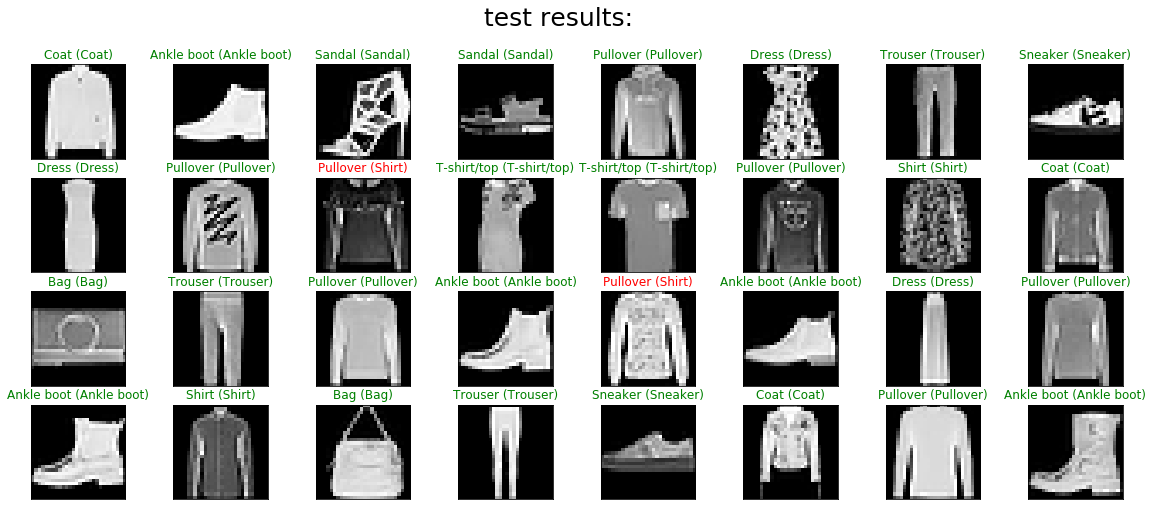

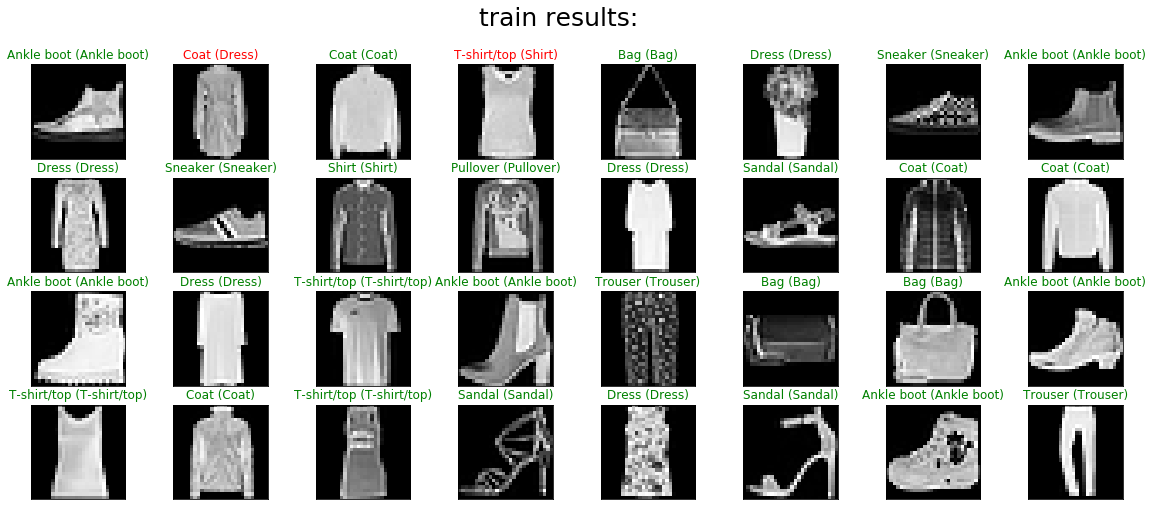

In [0]:
model.load_weights('model.weights.best.hdf5')
visualize_model_predictions(model, x_test, y_test, 'test')
visualize_model_predictions(model, x_train, y_train, 'train')
 
#Compute & compare train and test accuracies:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: %.2f%%' %(100*score[1]))
 
score = model.evaluate(x_train, y_train, verbose=0)
print('Train accuracy: %.2f%%' %(100*score[1]))

# 4 Data Augmentation
In the real world, getting enough training data is often a problem. To show the effect of this, training your architecture from above using only 100 training images, what is the best test-accuracy you can get now?

In [0]:
model = tf.keras.Sequential()

# You can use the previous model architecture:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
nr_samples_to_use = 100
batch_size = 32

callbacks_list = # Whatever you want to use

model.fit(x_train[:nr_samples_to_use],
         y_train[:nr_samples_to_use],
         batch_size=batch_size,
         epochs=50,
         validation_data=(x_valid, y_valid),
         callbacks=callbacks_list)

In [0]:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)

print('Test accuracy: %.2f%%' %(100*score[1]))

## Lets augment our small Training-dataset at runtime using an ImageDataGenerator():
See https://keras.io/preprocessing/image/

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training:
train_datagen = ImageDataGenerator( #ToDo )

# this is the augmentation configuration we will use for testing:
validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
train_datagen.fit(x_train)
validation_datagen.fit(x_valid)
test_datagen.fit(x_test)

## Plot a few batches of augmented images to check the result of your Data Augmentation parameters
Make sure you can still classify every augmented image yourself!

## Use the ImageDataGenerator to augment the small Train-subset at runtime.
What test-accuracy do you get now?

In [0]:
model = tf.keras.Sequential()

# Use the same model as before

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
callbacks_list = # Up to you

# fits the model on batches with real-time data augmentation:
model.fit_generator(generator = train_datagen.flow(x_train[:nr_samples_to_use], y_train[:nr_samples_to_use], batch_size=batch_size),
                    validation_data = validation_datagen.flow(x_valid, y_valid, batch_size=batch_size), 
                    steps_per_epoch = nr_samples_to_use // batch_size,
                    callbacks=callbacks_list,
                    use_multiprocessing=True,
                    workers=8,
                    epochs=100)

In [0]:
model.load_weights('model.weights.best.hdf5')
score = model.evaluate(x_test, y_test, verbose=0)

print('Test accuracy: %.2f%%' %(100*score[1]))

In [0]:
## Note: Data Augmentation on Fashion-MNIST is not the most effective. 
## But the concept is very generally usefull for a lot of Deep Learning problems, hence the inclusion here!

# Final assignment
### Finally, throw everything together and try to get the best possible performance on the Test-set! Who will win?

For the Pro's, here are some additional tips:
* Try Batch-Normalization layers
* Play around with the Data Augmentation parameters a lot: augmenting data is good, but you don't want to push your training data distribution to far out (the test-data is not augmented!!) For example: sneakers, sandals and boots are always facing left in the Fashion-MNIST dataset, so random-horizontal flipping isn't the best option here...
* You could also experiment with some of the newer activation functions like LeakyReLU, SeLU, ...
* Cyclical learning rates
* ...